**Sources:**

The code is a further development of this preliminary project:

[1] https://github.com/bjorneme/preliminary/tree/main

The state-of-the-art model used as inspiration for multi-label classification on ChestX-ray14 is:

[2] https://github.com/syednabilashraf/SynthEnsemble/tree/main

The code used for develop BYOL architecture is:

[3] https://docs.lightly.ai/self-supervised-learning/examples/byol.html

**Import Libraries**

In [1]:
pip install lightly mambavision transformers mamba_ssm timm

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Standard Libraries
import os
import copy
import random
from glob import glob
from PIL import Image
import zipfile

# Data Manipulation Libraries
import pandas as pd
import numpy as np

# Visualization Libraries
import matplotlib.pyplot as plt

# Progress Bar
from tqdm import tqdm

# Machine Learning Libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc, f1_score
from torch.amp import GradScaler, autocast

# BYOL library
from lightly.transforms.byol_transform import BYOLTransform, BYOLView1Transform, BYOLView2Transform
from lightly.models.modules import BYOLProjectionHead, BYOLPredictionHead
from lightly.models.utils import deactivate_requires_grad, update_momentum
from lightly.loss import NegativeCosineSimilarity
from lightly.utils.scheduler import cosine_schedule

# Hugging Face transformers to load the MambaVision model
from transformers import AutoModel

/cluster/home/bjorneme/.conda/envs/master_thesis/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


**Define Parameters**

In [3]:
# Paths
ZIP_PATH = '/cluster/home/bjorneme/projects/Data/chestX-ray14.zip'
EXTRACTED_PATH = '/cluster/home/bjorneme/projects/Data/chestX-ray14-extracted'

# Model
MODEL_NAME = "nvidia/MambaVision-T2-1K"

# Disease labels
disease_labels = [
    'Atelectasis', 'Consolidation', 'Infiltration', 'Pneumothorax', 'Edema',
    'Emphysema', 'Fibrosis', 'Effusion', 'Pneumonia', 'Pleural_Thickening',
    'Cardiomegaly', 'Nodule', 'Mass', 'Hernia'
]

# Parameters BYOL pre-training
LEARNING_RATE_BYOL = 0.06
EPOCHS_BYOL = 200
BATCH_SIZE_BYOL = 128

# Parameters training
LEARNING_RATE = 0.001
LEARNING_RATE_FINE_TUNING = 0.0001
EPOCHS = 3
EPOCHS_FINE_TUNING = 100
BATCH_SIZE = 32

# Parameters early stopping
EARLY_STOPPING_PATIENCE = 10

# Parameters learning rate scheduler
LEARNING_RATE_SCHEDULER_PATIENCE = 1
LEARNING_RATE_SCHEDULER_MODE = 'min'
LEARNING_RATE_SCHEDULER_FACTOR = 0.1

# Other parameters
SEED = 42
NUM_WORKERS = 32

# Device Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


**Set Seed for Reproducibility**

In [4]:
def seed_everything(seed=SEED):
    """
    Sets the seed to ensure reproducibility.
    """
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Apply the seed
seed_everything()

# **Step 1: Load Data**

In [5]:
def extract_data(zip_path, extracted_path):
    """
    Extracts the ZIP file of the dataset.
    """
    os.makedirs(extracted_path, exist_ok=True)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extracted_path)

# Extract ChestX-ray14 dataset
# extract_data(ZIP_PATH, EXTRACTED_PATH)

# **Step 2: Data Preprocessing**

In [6]:
def load_labels(csv_path, extracted_path):
    """
    Read labels from CSV, maps images to paths, and create binary disease labels.
    """

    # Read the CSV containing labels
    labels_df = pd.read_csv(csv_path)

    # Create binary columns for each disease label
    for disease in disease_labels:
        labels_df[disease] = labels_df['Finding Labels'].str.contains(disease).astype(int)

    # Create binary column for 'No Finding'
    labels_df['No Finding'] = labels_df['Finding Labels'].str.contains('No Finding').astype(int)

    # Map images to their full path
    labels_df['Path'] = labels_df['Image Index'].map(
        {os.path.basename(path): path for path in glob(os.path.join(extracted_path, '**', 'images', '*.png'))}
    )
    
    return labels_df

# Path to the labels CSV file
labels_csv_path = os.path.join(EXTRACTED_PATH, 'Data_Entry_2017.csv')

# Load and preprocess the labels
df = load_labels(labels_csv_path, EXTRACTED_PATH)

**Split Dataset**

In [7]:
# Split based on patients
unique_patients = df['Patient ID'].unique()

# Split patients into training, validation and test sets
train_val_patients, test_patients = train_test_split(
    unique_patients, test_size=0.2, random_state=SEED
)
train_patients, val_patients = train_test_split(
    train_val_patients, test_size=0.125, random_state=SEED
)

# Create dataframes for training, validation, and test sets
train_df = df[df['Patient ID'].isin(train_patients)].reset_index(drop=True)
val_df = df[df['Patient ID'].isin(val_patients)].reset_index(drop=True)
test_df = df[df['Patient ID'].isin(test_patients)].reset_index(drop=True)

# Verify Split Sizes
print(f"Train dataset size: {len(train_df)}. Number of unique patients: {len(train_patients)}")
print(f"Validation size: {len(val_df)}. Number of unique patients: {len(val_patients)}")
print(f"Test size: {len(test_df)}. Number of unique patients: {len(test_patients)}")

Train dataset size: 78614. Number of unique patients: 21563
Validation size: 11212. Number of unique patients: 3081
Test size: 22294. Number of unique patients: 6161


**Define Dataset for Chest X-ray images**

In [8]:
class ChestXrayDataset(Dataset):
    """
    Create dataset for Chest X-ray images.
    """
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        
        # Get image and labels
        img_path = self.df.iloc[idx]['Path']
        image = plt.imread(img_path)
        label = self.df.iloc[idx][disease_labels].values.astype(np.float32)
        
        # Apply transformation on image
        image = self.transform(image)
        
        return image, label

**Define Data Transformations**

In [9]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

# Define transformations for training data
train_transforms = transforms.Compose([

    # Convert image to PIL format
    transforms.ToPILImage(),

    # Convert to 3 channels
    transforms.Grayscale(num_output_channels=3),

    # Resize the image to 256x256
    transforms.Resize((256,256)),

    # Randomly 224x224 crops
    transforms.RandomCrop(224),

    # Apply random horizontal flip
    transforms.RandomHorizontalFlip(),

    # Randomly rotate the image with ±10 degrees
    transforms.RandomRotation(10),

    # Apply random brightness
    transforms.ColorJitter(
        brightness=(0.8, 1.2),
    ),

    # Apply random contrast
    transforms.ColorJitter(
        contrast=(0.8, 1.2),
    ),

    # Convert the image to a PyTorch tensor
    transforms.ToTensor(),

    # Normalize using ImageNet mean and std
    transforms.Normalize(mean=mean, std=std)
])

# Define transformations for test data
test_transforms = transforms.Compose([

    # Convert image to PIL format
    transforms.ToPILImage(),

    # Convert to 3 channels
    transforms.Grayscale(num_output_channels=3),

    # Resize the image to 256x256
    transforms.Resize((256,256)),

    # Create 10 crops
    transforms.TenCrop(224),
    transforms.Lambda(lambda crops: torch.stack([
        transforms.ToTensor()(crop) for crop in crops
    ])),

    # Normalize using ImageNet mean and std
    transforms.Lambda(lambda crops: torch.stack(
        [transforms.Normalize(mean, std)(crop) for crop in crops]
    ))
])

**Create Datasets**

In [10]:
train_dataset = ChestXrayDataset(train_df, transform=train_transforms)
val_dataset = ChestXrayDataset(val_df, transform=test_transforms)
test_dataset = ChestXrayDataset(test_df, transform=test_transforms)

**Create DataLoaders**

In [11]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

# **Step 3: BYOL Pre-training**

**Define the BYOL transformations**

In [12]:
def get_xray_transform():
    return transforms.Compose([
        
        # Convert image to PIL format
        transforms.ToPILImage(),

        # Convert to 3 channels
        transforms.Grayscale(num_output_channels=3),

        # Resize the image to 256x256
        transforms.Resize((256,256)),

        # Randomly 224x224 crops
        transforms.RandomCrop(224),

        # Apply random horizontal flip
        transforms.RandomHorizontalFlip(),

        # Randomly rotate the image with ±10 degrees
        transforms.RandomRotation(10),

        # Apply random brightness
        transforms.ColorJitter(
            brightness=(0.8, 1.2),
        ),

        # Apply random contrast
        transforms.ColorJitter(
            contrast=(0.8, 1.2),
        ),

        # Convert the image to a PyTorch tensor
        transforms.ToTensor(),

        # Normalize using ImageNet mean and std
        transforms.Normalize(mean=mean, std=std)
    ])

byol_transform = BYOLTransform(
    view_1_transform=get_xray_transform(),
    view_2_transform=get_xray_transform()
)

**Define the BYOL model**

In [13]:
class BYOL(nn.Module):
    def __init__(self, model_name="nvidia/MambaVision-T2-1K"):
        super().__init__()

        # The online network
        self.backbone = AutoModel.from_pretrained(model_name, trust_remote_code=True)
        self.projection_head = BYOLProjectionHead(self.backbone.model.head.in_features, 1024, 256)
        self.prediction_head = BYOLPredictionHead(256, 1024, 256)

        # The target network
        self.backbone_momentum = copy.deepcopy(self.backbone)
        self.projection_head_momentum = copy.deepcopy(self.projection_head)

        # Freeze the teacher network. Only update using EMA
        deactivate_requires_grad(self.backbone_momentum)
        deactivate_requires_grad(self.projection_head_momentum)

    def forward_student(self, x):
        # Forward pass student network
        y, _ = self.backbone(x)
        z = self.projection_head(y)
        p = self.prediction_head(z)
        return p

    def forward_teacher(self, x):
        # Forward pass teacher network
        y, _ = self.backbone_momentum(x)
        z = self.projection_head_momentum(y)
        return z.detach()

# Initalize BYOL model
byol_model = BYOL(MODEL_NAME).to(device)

/cluster/home/bjorneme/.conda/envs/master_thesis/lib/python3.11/site-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
/cluster/home/bjorneme/.conda/envs/master_thesis/lib/python3.11/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
2025-04-24 16:21:32.792414: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-24 16:21:53.111192: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:

**Create BYOL Dataset**

In [14]:
class BYOLDataset(torch.utils.data.Dataset):
    """
    Dataset for BYOL.
    Returns two augmented versions of each image.
    """
    def __init__(self, df, transform):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Get image path
        img_path = self.df.iloc[idx]['Path']
        image = plt.imread(img_path)

        # Apply the BYOL transform on image
        view1, view2 = self.transform(image)

        # Return two different views
        return view1, view2

# Create dataset for training and validation using BYOL
byol_train_dataset = BYOLDataset(train_df, transform=byol_transform)
byol_val_dataset = BYOLDataset(val_df, transform=byol_transform)

**Initialize BYOL DataLoader**

In [15]:
# Initialize loader for BYOL training
byol_train_loader = DataLoader(
    byol_train_dataset,
    batch_size=BATCH_SIZE_BYOL,
    shuffle=True,
    num_workers=NUM_WORKERS,
    drop_last=True
)

# Initialize loader for BYOL validation
byol_val_loader = DataLoader(
    byol_val_dataset,
    batch_size=BATCH_SIZE_BYOL,
    shuffle=False,
    num_workers=NUM_WORKERS,
    drop_last=False
)

**Initialize Optimizer and Loss for BYOL**

In [16]:
criterion = NegativeCosineSimilarity()
optimizer_byol = torch.optim.SGD(byol_model.parameters(), lr=LEARNING_RATE_BYOL)

**Train BYOL Model**

In [17]:
def train_model(byol_model, byol_train_loader, byol_val_loader, criterion, optimizer, patience, epochs=10):
    """
    Pre-train the backbone and evaluate it on the validation set after each epoch.
    """

    # List to store byol loss
    byol_train_losses = []
    byol_val_losses = []

    # Early stopping parameters
    best_loss = 0
    epochs_without_improvement = 0

    for epoch in range(epochs):


        # ---Training---
        byol_model.train()
        train_loss = 0.0

        # For mixed precision
        scaler = GradScaler()

        # Progress bar
        progress_bar = tqdm(byol_train_loader, desc=f"BYOL Epoch {epoch+1}/{epochs}")

        # Scheduler
        momentum_val = cosine_schedule(epoch, epochs, 0.996, 1)

        for batch in progress_bar:
            x0, x1 = batch
            update_momentum(byol_model.backbone, byol_model.backbone_momentum, m=momentum_val)
            update_momentum(byol_model.projection_head, byol_model.projection_head_momentum, m=momentum_val)

            x0 = x0.to(device)
            x1 = x1.to(device)

            # Clear gradients
            optimizer.zero_grad()

            with autocast('cuda'):

                # Forward pass
                p0 = byol_model.forward_student(x0)
                z0 = byol_model.forward_teacher(x0)
                p1 = byol_model.forward_student(x1)
                z1 = byol_model.forward_teacher(x1)

                # Compute loss
                loss = 0.5 * (criterion(p0, z1) + criterion(p1, z0))

            # Backward pass + scaling
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            train_loss += loss.item()
            progress_bar.set_postfix({"Loss": loss.item()})

        # Calculate average training loss
        train_loss = train_loss / len(byol_train_loader)
        byol_train_losses.append(train_loss)


        # ---Validation---
        byol_model.eval()
        val_loss = 0

        # Progress bar
        progress_bar = tqdm(byol_val_loader, desc=f"BYOL Epoch {epoch+1}/{epochs}")

        # Disable gradients for evaluation
        with torch.no_grad():
            for batch in progress_bar:
                x0, x1 = batch

                x0 = x0.to(device)
                x1 = x1.to(device)

                # Forward pass
                p0 = byol_model.forward_student(x0)
                z0 = byol_model.forward_teacher(x0)
                p1 = byol_model.forward_student(x1)
                z1 = byol_model.forward_teacher(x1)

                # Compute loss
                loss = 0.5 * (criterion(p0, z1) + criterion(p1, z0))

                val_loss  += loss.item()
                progress_bar.set_postfix({"Loss": loss.item()})

        # Calculate average validation loss
        val_loss = val_loss / len(byol_val_loader)
        byol_val_losses.append(val_loss)

        print(f"Epoch {epoch+1}/{epochs} | Training Loss: {train_loss:.4f} | "
              f"Validation Loss: {val_loss:.4f}")

        # Early stopping
        if best_loss > val_loss:

            # Reset early stopping parameters
            best_loss = val_loss
            epochs_without_improvement = 0

            # Save the best model
            torch.save(byol_model.state_dict(), 'byol_five_augmentation.pt')
            print(f"New best model with Validation Loss: {val_loss:.4f}")
        else:
            epochs_without_improvement += 1

            # Condition for doing early stopping
            if epochs_without_improvement >= patience :
                print(f"Early stopping.")
                break

    # Load the best model
    byol_model.load_state_dict(torch.load('byol_five_augmentation.pt', weights_only=True))

    return byol_train_losses, byol_val_losses

# Train the model
byol_train_losses, byol_val_losses = train_model(byol_model, byol_train_loader, byol_val_loader, criterion, optimizer_byol, EARLY_STOPPING_PATIENCE, EPOCHS_BYOL)

BYOL Epoch 1/200: 100%|██████████| 88/88 [00:48<00:00,  1.83it/s, Loss=-0.8]  


Epoch 1/200 | Training Loss: -0.6950 | Validation Loss: -0.8577
New best model with Validation Loss: -0.8577


BYOL Epoch 2/200: 100%|██████████| 88/88 [00:29<00:00,  3.02it/s, Loss=-0.905]


Epoch 2/200 | Training Loss: -0.8789 | Validation Loss: -0.9341
New best model with Validation Loss: -0.9341


BYOL Epoch 3/200: 100%|██████████| 88/88 [00:25<00:00,  3.49it/s, Loss=-0.921]


Epoch 3/200 | Training Loss: -0.9250 | Validation Loss: -0.9492
New best model with Validation Loss: -0.9492


BYOL Epoch 4/200: 100%|██████████| 88/88 [00:25<00:00,  3.42it/s, Loss=-0.947]


Epoch 4/200 | Training Loss: -0.9419 | Validation Loss: -0.9564
New best model with Validation Loss: -0.9564


BYOL Epoch 5/200: 100%|██████████| 88/88 [00:30<00:00,  2.89it/s, Loss=-0.949]


Epoch 5/200 | Training Loss: -0.9502 | Validation Loss: -0.9618
New best model with Validation Loss: -0.9618


BYOL Epoch 6/200: 100%|██████████| 88/88 [00:25<00:00,  3.39it/s, Loss=-0.969]


Epoch 6/200 | Training Loss: -0.9555 | Validation Loss: -0.9719
New best model with Validation Loss: -0.9719


BYOL Epoch 7/200: 100%|██████████| 88/88 [00:25<00:00,  3.42it/s, Loss=-0.944]


Epoch 7/200 | Training Loss: -0.9593 | Validation Loss: -0.9466


BYOL Epoch 8/200: 100%|██████████| 88/88 [00:25<00:00,  3.40it/s, Loss=-0.967]


Epoch 8/200 | Training Loss: -0.9623 | Validation Loss: -0.9761
New best model with Validation Loss: -0.9761


BYOL Epoch 9/200: 100%|██████████| 88/88 [00:25<00:00,  3.42it/s, Loss=-0.972]


Epoch 9/200 | Training Loss: -0.9646 | Validation Loss: -0.9777
New best model with Validation Loss: -0.9777


BYOL Epoch 10/200: 100%|██████████| 88/88 [00:25<00:00,  3.47it/s, Loss=-0.969]


Epoch 10/200 | Training Loss: -0.9663 | Validation Loss: -0.9756


BYOL Epoch 11/200: 100%|██████████| 88/88 [00:25<00:00,  3.48it/s, Loss=-0.975]


Epoch 11/200 | Training Loss: -0.9677 | Validation Loss: -0.9803
New best model with Validation Loss: -0.9803


BYOL Epoch 12/200: 100%|██████████| 88/88 [00:25<00:00,  3.47it/s, Loss=-0.974]


Epoch 12/200 | Training Loss: -0.9689 | Validation Loss: -0.9804
New best model with Validation Loss: -0.9804


BYOL Epoch 13/200: 100%|██████████| 88/88 [00:25<00:00,  3.46it/s, Loss=-0.974]


Epoch 13/200 | Training Loss: -0.9699 | Validation Loss: -0.9807
New best model with Validation Loss: -0.9807


BYOL Epoch 14/200: 100%|██████████| 88/88 [00:24<00:00,  3.57it/s, Loss=-0.976]


Epoch 14/200 | Training Loss: -0.9708 | Validation Loss: -0.9787


BYOL Epoch 15/200: 100%|██████████| 88/88 [00:25<00:00,  3.44it/s, Loss=-0.974]


Epoch 15/200 | Training Loss: -0.9715 | Validation Loss: -0.9780


BYOL Epoch 16/200: 100%|██████████| 88/88 [00:26<00:00,  3.37it/s, Loss=-0.977]


Epoch 16/200 | Training Loss: -0.9722 | Validation Loss: -0.9812
New best model with Validation Loss: -0.9812


BYOL Epoch 17/200: 100%|██████████| 88/88 [00:27<00:00,  3.20it/s, Loss=-0.973]


Epoch 17/200 | Training Loss: -0.9729 | Validation Loss: -0.9773


BYOL Epoch 18/200: 100%|██████████| 88/88 [00:25<00:00,  3.39it/s, Loss=-0.978]


Epoch 18/200 | Training Loss: -0.9736 | Validation Loss: -0.9814
New best model with Validation Loss: -0.9814


BYOL Epoch 19/200: 100%|██████████| 88/88 [00:24<00:00,  3.57it/s, Loss=-0.982]


Epoch 19/200 | Training Loss: -0.9742 | Validation Loss: -0.9839
New best model with Validation Loss: -0.9839


BYOL Epoch 20/200: 100%|██████████| 88/88 [00:26<00:00,  3.38it/s, Loss=-0.98] 


Epoch 20/200 | Training Loss: -0.9748 | Validation Loss: -0.9839
New best model with Validation Loss: -0.9839


BYOL Epoch 21/200: 100%|██████████| 88/88 [00:25<00:00,  3.44it/s, Loss=-0.98] 


Epoch 21/200 | Training Loss: -0.9752 | Validation Loss: -0.9840
New best model with Validation Loss: -0.9840


BYOL Epoch 22/200: 100%|██████████| 88/88 [00:25<00:00,  3.39it/s, Loss=-0.982]


Epoch 22/200 | Training Loss: -0.9757 | Validation Loss: -0.9848
New best model with Validation Loss: -0.9848


BYOL Epoch 23/200: 100%|██████████| 88/88 [00:29<00:00,  3.03it/s, Loss=-0.981]


Epoch 23/200 | Training Loss: -0.9761 | Validation Loss: -0.9851
New best model with Validation Loss: -0.9851


BYOL Epoch 24/200: 100%|██████████| 88/88 [00:25<00:00,  3.41it/s, Loss=-0.982]


Epoch 24/200 | Training Loss: -0.9765 | Validation Loss: -0.9835


BYOL Epoch 25/200: 100%|██████████| 88/88 [00:25<00:00,  3.41it/s, Loss=-0.982]


Epoch 25/200 | Training Loss: -0.9768 | Validation Loss: -0.9828


BYOL Epoch 26/200: 100%|██████████| 88/88 [00:25<00:00,  3.42it/s, Loss=-0.981]


Epoch 26/200 | Training Loss: -0.9772 | Validation Loss: -0.9843


BYOL Epoch 27/200: 100%|██████████| 88/88 [00:25<00:00,  3.42it/s, Loss=-0.98] 


Epoch 27/200 | Training Loss: -0.9775 | Validation Loss: -0.9830


BYOL Epoch 28/200: 100%|██████████| 88/88 [00:25<00:00,  3.39it/s, Loss=-0.982]


Epoch 28/200 | Training Loss: -0.9776 | Validation Loss: -0.9863
New best model with Validation Loss: -0.9863


BYOL Epoch 29/200: 100%|██████████| 88/88 [00:25<00:00,  3.43it/s, Loss=-0.983]


Epoch 29/200 | Training Loss: -0.9780 | Validation Loss: -0.9846


BYOL Epoch 30/200: 100%|██████████| 88/88 [00:25<00:00,  3.45it/s, Loss=-0.981]


Epoch 30/200 | Training Loss: -0.9783 | Validation Loss: -0.9829


BYOL Epoch 31/200: 100%|██████████| 88/88 [00:26<00:00,  3.38it/s, Loss=-0.983]


Epoch 31/200 | Training Loss: -0.9785 | Validation Loss: -0.9863


BYOL Epoch 32/200: 100%|██████████| 88/88 [00:25<00:00,  3.41it/s, Loss=-0.984]


Epoch 32/200 | Training Loss: -0.9787 | Validation Loss: -0.9869
New best model with Validation Loss: -0.9869


BYOL Epoch 33/200: 100%|██████████| 88/88 [00:25<00:00,  3.47it/s, Loss=-0.984]


Epoch 33/200 | Training Loss: -0.9790 | Validation Loss: -0.9842


BYOL Epoch 34/200: 100%|██████████| 88/88 [00:25<00:00,  3.45it/s, Loss=-0.982]


Epoch 34/200 | Training Loss: -0.9792 | Validation Loss: -0.9847


BYOL Epoch 35/200: 100%|██████████| 88/88 [00:24<00:00,  3.52it/s, Loss=-0.985]


Epoch 35/200 | Training Loss: -0.9793 | Validation Loss: -0.9868


BYOL Epoch 36/200: 100%|██████████| 88/88 [00:25<00:00,  3.50it/s, Loss=-0.983]


Epoch 36/200 | Training Loss: -0.9795 | Validation Loss: -0.9846


BYOL Epoch 37/200: 100%|██████████| 88/88 [00:24<00:00,  3.54it/s, Loss=-0.985]


Epoch 37/200 | Training Loss: -0.9796 | Validation Loss: -0.9870
New best model with Validation Loss: -0.9870


BYOL Epoch 38/200: 100%|██████████| 88/88 [00:24<00:00,  3.57it/s, Loss=-0.983]


Epoch 38/200 | Training Loss: -0.9797 | Validation Loss: -0.9872
New best model with Validation Loss: -0.9872


BYOL Epoch 39/200: 100%|██████████| 88/88 [00:25<00:00,  3.50it/s, Loss=-0.983]


Epoch 39/200 | Training Loss: -0.9798 | Validation Loss: -0.9872
New best model with Validation Loss: -0.9872


BYOL Epoch 40/200: 100%|██████████| 88/88 [00:24<00:00,  3.63it/s, Loss=-0.984]


Epoch 40/200 | Training Loss: -0.9799 | Validation Loss: -0.9864


BYOL Epoch 41/200: 100%|██████████| 88/88 [00:25<00:00,  3.52it/s, Loss=-0.984]


Epoch 41/200 | Training Loss: -0.9801 | Validation Loss: -0.9867


BYOL Epoch 42/200: 100%|██████████| 88/88 [00:25<00:00,  3.43it/s, Loss=-0.983]


Epoch 42/200 | Training Loss: -0.9802 | Validation Loss: -0.9871


BYOL Epoch 43/200: 100%|██████████| 88/88 [00:25<00:00,  3.45it/s, Loss=-0.984]


Epoch 43/200 | Training Loss: -0.9803 | Validation Loss: -0.9870


BYOL Epoch 44/200: 100%|██████████| 88/88 [00:25<00:00,  3.51it/s, Loss=-0.985]


Epoch 44/200 | Training Loss: -0.9804 | Validation Loss: -0.9873
New best model with Validation Loss: -0.9873


BYOL Epoch 45/200: 100%|██████████| 88/88 [00:25<00:00,  3.42it/s, Loss=-0.984]


Epoch 45/200 | Training Loss: -0.9804 | Validation Loss: -0.9856


BYOL Epoch 46/200: 100%|██████████| 88/88 [00:24<00:00,  3.55it/s, Loss=-0.985]


Epoch 46/200 | Training Loss: -0.9805 | Validation Loss: -0.9872


BYOL Epoch 47/200: 100%|██████████| 88/88 [00:25<00:00,  3.47it/s, Loss=-0.985]


Epoch 47/200 | Training Loss: -0.9807 | Validation Loss: -0.9876
New best model with Validation Loss: -0.9876


BYOL Epoch 48/200: 100%|██████████| 88/88 [00:25<00:00,  3.52it/s, Loss=-0.984]


Epoch 48/200 | Training Loss: -0.9806 | Validation Loss: -0.9861


BYOL Epoch 49/200: 100%|██████████| 88/88 [00:25<00:00,  3.48it/s, Loss=-0.985]


Epoch 49/200 | Training Loss: -0.9807 | Validation Loss: -0.9878
New best model with Validation Loss: -0.9878


BYOL Epoch 50/200: 100%|██████████| 88/88 [00:24<00:00,  3.58it/s, Loss=-0.985]


Epoch 50/200 | Training Loss: -0.9807 | Validation Loss: -0.9878


BYOL Epoch 51/200: 100%|██████████| 88/88 [00:25<00:00,  3.43it/s, Loss=-0.985]


Epoch 51/200 | Training Loss: -0.9808 | Validation Loss: -0.9873


BYOL Epoch 52/200: 100%|██████████| 88/88 [00:25<00:00,  3.51it/s, Loss=-0.984]


Epoch 52/200 | Training Loss: -0.9809 | Validation Loss: -0.9864


BYOL Epoch 53/200: 100%|██████████| 88/88 [00:24<00:00,  3.57it/s, Loss=-0.981]


Epoch 53/200 | Training Loss: -0.9810 | Validation Loss: -0.9840


BYOL Epoch 54/200: 100%|██████████| 88/88 [00:24<00:00,  3.62it/s, Loss=-0.986]


Epoch 54/200 | Training Loss: -0.9811 | Validation Loss: -0.9878


BYOL Epoch 55/200: 100%|██████████| 88/88 [00:25<00:00,  3.44it/s, Loss=-0.985]


Epoch 55/200 | Training Loss: -0.9811 | Validation Loss: -0.9878


BYOL Epoch 56/200: 100%|██████████| 88/88 [00:25<00:00,  3.50it/s, Loss=-0.986]


Epoch 56/200 | Training Loss: -0.9812 | Validation Loss: -0.9868


BYOL Epoch 57/200: 100%|██████████| 88/88 [00:25<00:00,  3.52it/s, Loss=-0.985]


Epoch 57/200 | Training Loss: -0.9812 | Validation Loss: -0.9881
New best model with Validation Loss: -0.9881


BYOL Epoch 58/200: 100%|██████████| 88/88 [00:24<00:00,  3.58it/s, Loss=-0.985]


Epoch 58/200 | Training Loss: -0.9812 | Validation Loss: -0.9879


BYOL Epoch 59/200: 100%|██████████| 88/88 [00:25<00:00,  3.50it/s, Loss=-0.981]


Epoch 59/200 | Training Loss: -0.9813 | Validation Loss: -0.9822


BYOL Epoch 60/200: 100%|██████████| 88/88 [00:24<00:00,  3.53it/s, Loss=-0.985]


Epoch 60/200 | Training Loss: -0.9813 | Validation Loss: -0.9882
New best model with Validation Loss: -0.9882


BYOL Epoch 61/200: 100%|██████████| 88/88 [00:25<00:00,  3.48it/s, Loss=-0.986]


Epoch 61/200 | Training Loss: -0.9813 | Validation Loss: -0.9880


BYOL Epoch 62/200: 100%|██████████| 88/88 [00:25<00:00,  3.44it/s, Loss=-0.984]


Epoch 62/200 | Training Loss: -0.9813 | Validation Loss: -0.9857


BYOL Epoch 63/200: 100%|██████████| 88/88 [00:25<00:00,  3.46it/s, Loss=-0.983]


Epoch 63/200 | Training Loss: -0.9813 | Validation Loss: -0.9866


BYOL Epoch 64/200: 100%|██████████| 88/88 [00:25<00:00,  3.48it/s, Loss=-0.984]


Epoch 64/200 | Training Loss: -0.9813 | Validation Loss: -0.9872


BYOL Epoch 65/200: 100%|██████████| 88/88 [00:25<00:00,  3.48it/s, Loss=-0.985]


Epoch 65/200 | Training Loss: -0.9813 | Validation Loss: -0.9874


BYOL Epoch 66/200: 100%|██████████| 88/88 [00:25<00:00,  3.47it/s, Loss=-0.985]


Epoch 66/200 | Training Loss: -0.9813 | Validation Loss: -0.9878


BYOL Epoch 67/200: 100%|██████████| 88/88 [00:25<00:00,  3.46it/s, Loss=-0.984]


Epoch 67/200 | Training Loss: -0.9812 | Validation Loss: -0.9868


BYOL Epoch 68/200: 100%|██████████| 88/88 [00:25<00:00,  3.47it/s, Loss=-0.984]


Epoch 68/200 | Training Loss: -0.9812 | Validation Loss: -0.9874


BYOL Epoch 69/200: 100%|██████████| 88/88 [00:25<00:00,  3.51it/s, Loss=-0.981]


Epoch 69/200 | Training Loss: -0.9811 | Validation Loss: -0.9821


BYOL Epoch 70/200: 100%|██████████| 88/88 [00:25<00:00,  3.43it/s, Loss=-0.986]


Epoch 70/200 | Training Loss: -0.9811 | Validation Loss: -0.9878
Early stopping.


# **Step 4: Build the Model**

**Initialize the Multi-Label Classifier Model**

In [18]:
# Define the model
class MultiLabelClassifier(nn.Module):
    """
    Multi-Label Classification Model using MambaVision as the base model.
    """
    def __init__(self, backbone, num_classes=len(disease_labels)):
        super(MultiLabelClassifier, self).__init__()

        # Load pre-trained MambaVision model
        self.base_model = backbone.backbone

        # Replace the classification head to match the number of disease labels
        self.base_model.model.head = nn.Linear(self.base_model.model.head.in_features, num_classes)

    def forward(self, x):
        avg_pool, _ = self.base_model(x)
        return self.base_model.model.head(avg_pool)

# Initialize the Model
model = MultiLabelClassifier(byol_model)
model.to(device)

MultiLabelClassifier(
  (base_model): MambaVisionModel(
    (model): MambaVision(
      (patch_embed): PatchEmbed(
        (proj): Identity()
        (conv_down): Sequential(
          (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (1): BatchNorm2d(32, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Conv2d(32, 80, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (4): BatchNorm2d(80, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
          (5): ReLU()
        )
      )
      (levels): ModuleList(
        (0): MambaVisionLayer(
          (blocks): ModuleList(
            (0): ConvBlock(
              (conv1): Conv2d(80, 80, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
              (norm1): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (act1): GELU(approximate='tanh')
              (conv2): Conv2

**Use Multiple GPUs**

In [19]:
model = nn.DataParallel(model)

# **Step 5: Train the Model**

**Training Loop  Function**

In [20]:
def train_model(model, train_loader, val_loader, criterion, optimizer, patience, epochs=10):

    """
    Trains the model and evaluates it on the validation set after each epoch.
    """
    # List to store loss and AUC
    train_losses = []
    val_losses = []
    val_aucs = []

    # For mixed precision
    scaler = GradScaler()

    # Early stopping parameters
    best_score = 0
    epochs_without_improvement = 0

    for epoch in range(epochs):

        # Training
        model.train()
        train_loss = 0.0

        # Progress bar
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")

        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)

            # Clear gradients
            optimizer.zero_grad()

            with autocast('cuda'):

                # Forward pass
                outputs = model(inputs)

                # Compute loss
                loss = criterion(outputs, labels)

            # Backward pass + scaling
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            train_loss += loss.item() * inputs.size(0)
            progress_bar.set_postfix({"Loss": loss.item()})

        # Calculate average training loss
        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)

        # Validation
        model.eval()
        val_loss = 0.0
        all_labels = []
        all_preds = []

        # Progress bar
        progress_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs}")

        # Disable gradients for evaluation
        with torch.no_grad():
            for inputs, labels in progress_bar:
                
                # Retrieve input sizes
                batch_size, ncrops, C, H, W = inputs.size()

                # Move to device
                inputs, labels = inputs.to(device), labels.to(device)

                # Change to [batch_size * ncrops, C, H, W]
                inputs = inputs.view(-1, C, H, W)  

                with autocast('cuda'):

                    # Forward pass
                    outputs = model(inputs)

                    # Change to [batch_size * ncrops, C, H, W] and average
                    outputs = outputs.view(batch_size, ncrops, -1).mean(1)

                    # Compute loss
                    loss = criterion(outputs, labels)
                
                val_loss += loss.item() * inputs.size(0)

                # Apply sigmoid
                preds = torch.sigmoid(outputs).cpu()

                # Store predictions and true labels
                all_preds.append(preds)
                all_labels.append(labels.cpu())
                
                progress_bar.set_postfix({"Loss": loss.item()})

        # Calculate average validation loss
        val_loss /= (len(val_loader.dataset)*10)
        val_losses.append(val_loss)

        # Concatenate all batches
        preds = torch.cat(all_preds)
        labels = torch.cat(all_labels)
    
        roc_auc_per_label = []

        # Compute metrics for each label
        for i, label in enumerate(disease_labels):

            # Calculate ROC AUC
            roc_auc = roc_auc_score(labels[:, i].numpy(), preds[:, i].numpy())
            roc_auc_per_label.append(roc_auc)

        # Calculate and add overall metrics
        mean_auc = np.mean(roc_auc_per_label)
        val_aucs.append(mean_auc)

        # Update the scheduler
        scheduler.step(val_loss)
        
        print(f"Epoch {epoch+1}/{epochs} | Training Loss: {train_loss:.4f} | "
              f"Validation Loss: {val_loss:.4f} | Validation mAUC: {mean_auc:.4f}")

        # Early stopping
        if mean_auc > best_score:
            best_score = mean_auc
            epochs_without_improvement = 0
            torch.save(model.state_dict(), 'best_model_five_augmentations.pt')
            print(f"New best model with Validation mAUC: {mean_auc:.4f}")
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print(f"Early stopping.")
                break

    # Load the best model
    model.load_state_dict(torch.load('best_model_five_augmentations.pt', weights_only=True))

    return train_losses, val_losses, val_aucs

### **Step 1: Train Classification Head Only**

**Freeze the Backbone Parameters**

In [21]:
for name, param in model.named_parameters():
    if "head" not in name:
        param.requires_grad = False

**Initialize Loss Function, Optimizer and Scheduler**

In [22]:
criterion = nn.BCEWithLogitsLoss()
optimizer_head = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_head, factor=LEARNING_RATE_SCHEDULER_FACTOR, patience=LEARNING_RATE_SCHEDULER_PATIENCE, mode=LEARNING_RATE_SCHEDULER_MODE)

**Train the Model**

In [23]:
train_losses_1, val_losses_1, val_aucs_1 = train_model(model, train_loader, val_loader, criterion, optimizer_head, EARLY_STOPPING_PATIENCE, EPOCHS)

Epoch 1/3: 100%|██████████| 351/351 [00:40<00:00,  8.67it/s, Loss=0.14]  


Epoch 1/3 | Training Loss: 0.2306 | Validation Loss: 0.1665 | Validation mAUC: 0.7110
New best model with Validation mAUC: 0.7110


Epoch 2/3: 100%|██████████| 351/351 [00:41<00:00,  8.55it/s, Loss=0.142] 


Epoch 2/3 | Training Loss: 0.1696 | Validation Loss: 0.1635 | Validation mAUC: 0.7314
New best model with Validation mAUC: 0.7314


Epoch 3/3: 100%|██████████| 351/351 [00:40<00:00,  8.56it/s, Loss=0.141] 


Epoch 3/3 | Training Loss: 0.1671 | Validation Loss: 0.1624 | Validation mAUC: 0.7465
New best model with Validation mAUC: 0.7465


### **Step 2: Fine Tune Entire Network**

**Unfreeze All Layers**

In [24]:
for param in model.parameters():
    param.requires_grad = True

**Initialize Optimizer and Scheduler**

In [25]:
optimizer_full = optim.Adam(model.parameters(), lr=LEARNING_RATE_FINE_TUNING)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_full, factor=LEARNING_RATE_SCHEDULER_FACTOR, patience=LEARNING_RATE_SCHEDULER_PATIENCE, mode=LEARNING_RATE_SCHEDULER_MODE)

**Train the Model**

In [26]:
train_losses_2, val_losses_2, val_aucs_2 = train_model(model, train_loader, val_loader, criterion, optimizer_full, EARLY_STOPPING_PATIENCE, EPOCHS_FINE_TUNING)

Epoch 1/100:   0%|          | 0/2457 [00:00<?, ?it/s]

Epoch 1/100: 100%|██████████| 351/351 [00:40<00:00,  8.61it/s, Loss=0.119] 


Epoch 1/100 | Training Loss: 0.1601 | Validation Loss: 0.1497 | Validation mAUC: 0.8070
New best model with Validation mAUC: 0.8070


Epoch 2/100: 100%|██████████| 351/351 [00:40<00:00,  8.58it/s, Loss=0.111] 


Epoch 2/100 | Training Loss: 0.1521 | Validation Loss: 0.1464 | Validation mAUC: 0.8259
New best model with Validation mAUC: 0.8259


Epoch 3/100: 100%|██████████| 351/351 [00:40<00:00,  8.63it/s, Loss=0.112] 


Epoch 3/100 | Training Loss: 0.1481 | Validation Loss: 0.1446 | Validation mAUC: 0.8316
New best model with Validation mAUC: 0.8316


Epoch 4/100: 100%|██████████| 351/351 [00:41<00:00,  8.48it/s, Loss=0.113] 


Epoch 4/100 | Training Loss: 0.1454 | Validation Loss: 0.1436 | Validation mAUC: 0.8381
New best model with Validation mAUC: 0.8381


Epoch 5/100: 100%|██████████| 351/351 [00:40<00:00,  8.67it/s, Loss=0.113] 


Epoch 5/100 | Training Loss: 0.1430 | Validation Loss: 0.1423 | Validation mAUC: 0.8434
New best model with Validation mAUC: 0.8434


Epoch 6/100: 100%|██████████| 351/351 [00:40<00:00,  8.72it/s, Loss=0.112] 


Epoch 6/100 | Training Loss: 0.1406 | Validation Loss: 0.1428 | Validation mAUC: 0.8416


Epoch 7/100: 100%|██████████| 351/351 [00:40<00:00,  8.67it/s, Loss=0.109] 


Epoch 7/100 | Training Loss: 0.1386 | Validation Loss: 0.1431 | Validation mAUC: 0.8428


Epoch 8/100: 100%|██████████| 351/351 [00:41<00:00,  8.54it/s, Loss=0.114] 


Epoch 8/100 | Training Loss: 0.1318 | Validation Loss: 0.1410 | Validation mAUC: 0.8502
New best model with Validation mAUC: 0.8502


Epoch 9/100: 100%|██████████| 351/351 [00:39<00:00,  8.87it/s, Loss=0.113] 


Epoch 9/100 | Training Loss: 0.1296 | Validation Loss: 0.1411 | Validation mAUC: 0.8492


Epoch 10/100: 100%|██████████| 351/351 [00:39<00:00,  8.83it/s, Loss=0.112] 


Epoch 10/100 | Training Loss: 0.1287 | Validation Loss: 0.1416 | Validation mAUC: 0.8484


Epoch 11/100: 100%|██████████| 351/351 [00:39<00:00,  8.93it/s, Loss=0.109] 


Epoch 11/100 | Training Loss: 0.1272 | Validation Loss: 0.1417 | Validation mAUC: 0.8483


Epoch 12/100: 100%|██████████| 351/351 [00:39<00:00,  8.78it/s, Loss=0.108] 


Epoch 12/100 | Training Loss: 0.1269 | Validation Loss: 0.1417 | Validation mAUC: 0.8476


Epoch 13/100: 100%|██████████| 351/351 [00:40<00:00,  8.75it/s, Loss=0.11]  


Epoch 13/100 | Training Loss: 0.1269 | Validation Loss: 0.1417 | Validation mAUC: 0.8475


Epoch 14/100: 100%|██████████| 351/351 [00:40<00:00,  8.62it/s, Loss=0.11]  


Epoch 14/100 | Training Loss: 0.1270 | Validation Loss: 0.1417 | Validation mAUC: 0.8480


Epoch 15/100: 100%|██████████| 351/351 [00:39<00:00,  8.82it/s, Loss=0.11]  


Epoch 15/100 | Training Loss: 0.1268 | Validation Loss: 0.1420 | Validation mAUC: 0.8481


Epoch 16/100: 100%|██████████| 351/351 [00:40<00:00,  8.71it/s, Loss=0.111] 


Epoch 16/100 | Training Loss: 0.1269 | Validation Loss: 0.1418 | Validation mAUC: 0.8477


Epoch 17/100: 100%|██████████| 351/351 [00:40<00:00,  8.64it/s, Loss=0.108] 


Epoch 17/100 | Training Loss: 0.1268 | Validation Loss: 0.1418 | Validation mAUC: 0.8477


Epoch 18/100: 100%|██████████| 351/351 [00:39<00:00,  8.84it/s, Loss=0.109] 


Epoch 18/100 | Training Loss: 0.1269 | Validation Loss: 0.1418 | Validation mAUC: 0.8476
Early stopping.


# **Step 6: Evaluate the Model**

**Evaluate the Model on Test Set**

In [27]:
def evaluate_model(model, test_loader):
    """
    Evaluate the model on the test set.
    """

    # Store all predictions
    all_preds = []
    all_labels = []

    # Progress bar
    progress_bar = tqdm(test_loader, desc="Evaluating on Test Set")

    # Set to evaluation mode
    model.eval()

    # Disable gradients for evaluation
    with torch.no_grad():
        for inputs, labels in progress_bar:
            # Retrieve input sizes
            batch_size, ncrops, C, H, W = inputs.size()

            # Move to device
            inputs, labels = inputs.to(device), labels.to(device)

            # Change to [batch_size * ncrops, C, H, W]
            inputs = inputs.view(-1, C, H, W)  

            # Forward pass
            outputs = model(inputs)

            # Change to [batch_size * ncrops, C, H, W] and average
            outputs = outputs.view(batch_size, ncrops, -1).mean(1)

            # Apply sigmoid
            predictions = torch.sigmoid(outputs)

            # Store predictions and true labels
            all_preds.append(predictions.cpu())
            all_labels.append(labels.cpu())

    # Concatenate all batches
    predictions = torch.cat(all_preds)
    labels = torch.cat(all_labels)
    
    return predictions, labels

# Retrive predictions and true labels
predictions, labels = evaluate_model(model, test_loader)

Evaluating on Test Set: 100%|██████████| 697/697 [01:56<00:00,  6.01it/s]


**Compute Metrics for Each Label**

In [28]:
# Dictionaries for storing metrics
accuracy_per_label, f1_score_per_label, mean_auc_per_label = {}, {}, {}

# Compute metrics for each label
for i, label in enumerate(disease_labels):

    # Create binary predictions
    binary_predictions = predictions[:, i] > 0.5

    # Calculate accuracy
    accuracy_per_label[label] = accuracy_score(labels[:, i], binary_predictions)

    # Calculate f1 score
    f1_score_per_label[label] = f1_score(labels[:, i], binary_predictions, average='macro')

    # Calculate mAUC
    mean_auc_per_label[label] = roc_auc_score(labels[:, i], predictions[:, i])

# Create a df with metrics
metrics_df = pd.DataFrame({
    'Accuracy': accuracy_per_label,
    'F1 Score': f1_score_per_label,
    'mAUC': mean_auc_per_label
})

# Calculate the mean for all diseases
metrics_df.loc['Overall'] = metrics_df.mean()

**Print Metrics**

In [29]:
metrics_df

,Accuracy,F1 Score,mAUC
Atelectasis,0.901588,0.625273,0.831396
Consolidation,0.957119,0.491127,0.821880
Infiltration,0.814300,0.549519,0.715084
Pneumothorax,0.954651,0.638456,0.883570
Edema,0.978784,0.522580,0.896074
Emphysema,0.976182,0.649583,0.925589
Fibrosis,0.983538,0.511680,0.813296
Effusion,0.901139,0.711686,0.887568
Pneumonia,0.986813,0.496681,0.756819
Pleural_Thickening,0.969947,0.517862,0.803597


**Plot ROC curves for each label**

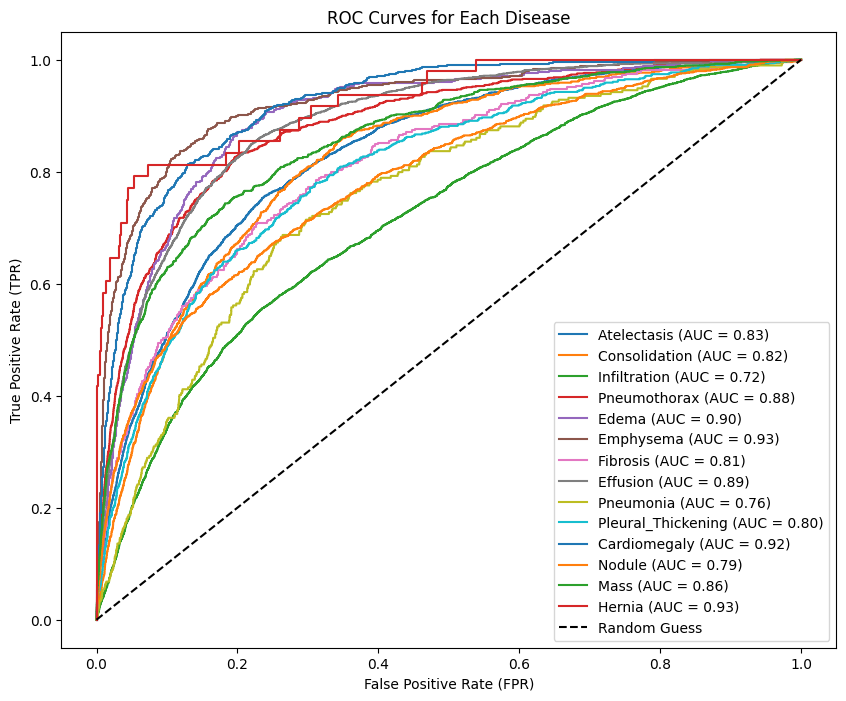

In [30]:
plt.figure(figsize=(10, 8))
for i, label in enumerate(disease_labels):
    fpr, tpr, _ = roc_curve(labels[:, i], predictions[:, i])
    plt.plot(fpr, tpr, label=f"{label} (AUC = {mean_auc_per_label[label]:.2f})")

plt.plot([0, 1], [0, 1], linestyle='--', color='black', label="Random Guess")
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curves for Each Disease')
plt.legend(loc='lower right')
plt.show()

**Plot Training and Validation Loss**

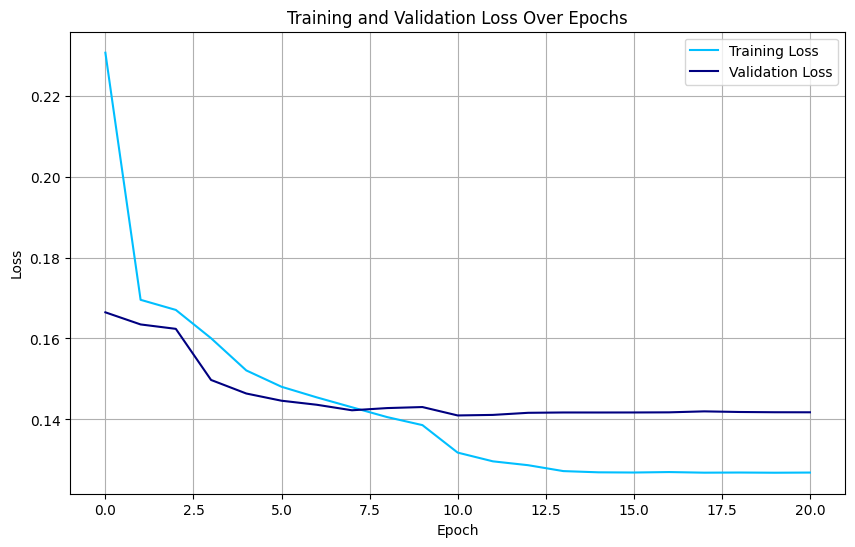

In [31]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses_1 + train_losses_2, label='Training Loss', color='deepskyblue')
plt.plot(val_losses_1 + val_losses_2, label='Validation Loss', color='navy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

**Plot Training and Validation Loss only Fine-tuning**

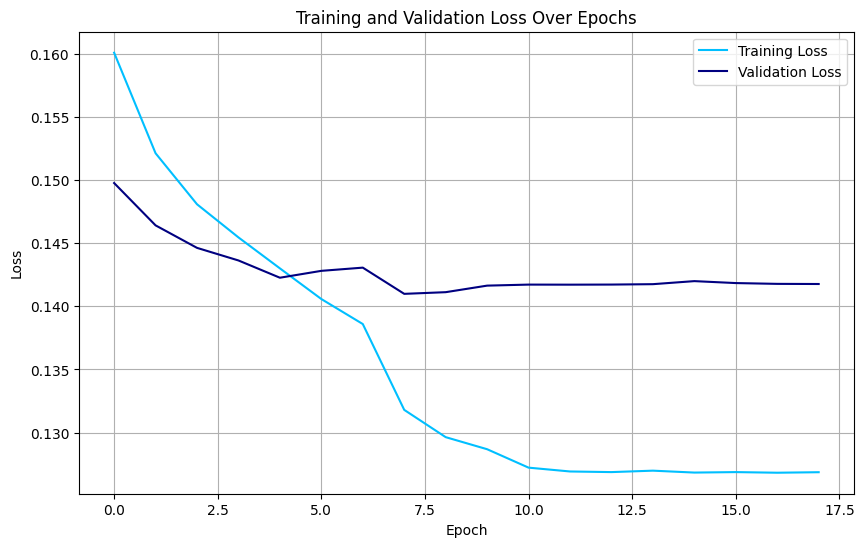

In [32]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses_2, label='Training Loss', color='deepskyblue')
plt.plot(val_losses_2, label='Validation Loss', color='navy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

**Plot Validation AUC**

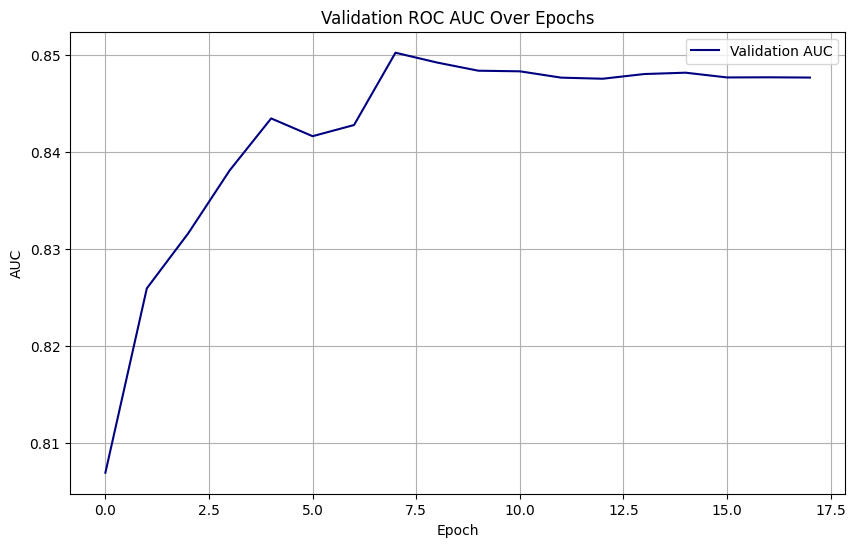

In [33]:
plt.figure(figsize=(10, 6))
plt.plot(val_aucs_2, label='Validation AUC', color='navy')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.title('Validation ROC AUC Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

**Plot Validation AUC only Fine-tuning**

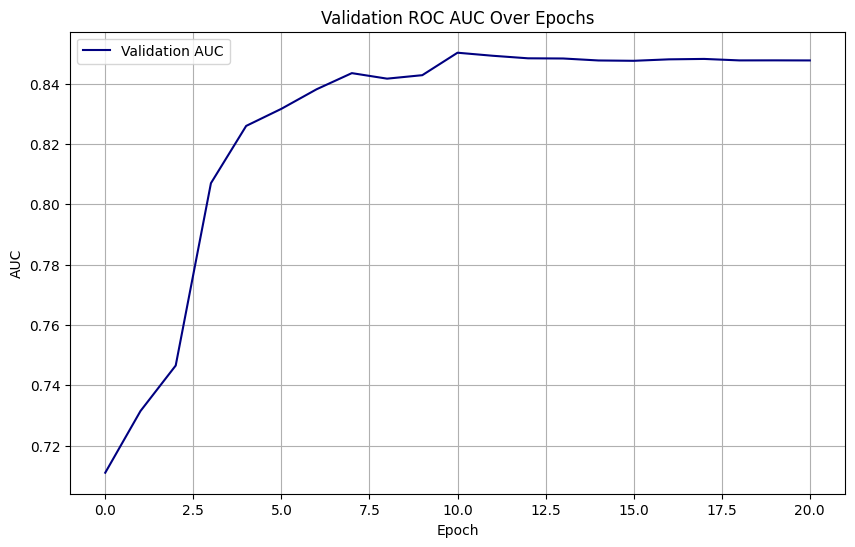

In [34]:
plt.figure(figsize=(10, 6))
plt.plot(val_aucs_1 + val_aucs_2, label='Validation AUC', color='navy')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.title('Validation ROC AUC Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

**Plot BYOL Loss**

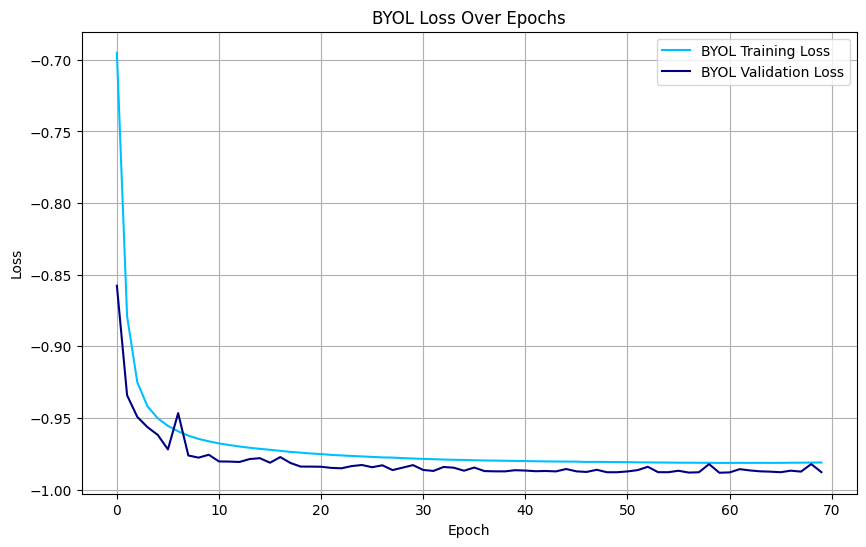

In [35]:
plt.figure(figsize=(10, 6))
plt.plot(byol_train_losses, label='BYOL Training Loss', color='deepskyblue')
plt.plot(byol_val_losses, label='BYOL Validation Loss', color='navy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('BYOL Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()